In [1]:
#%% Libraries import
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions

from Bin.Training import Training_1D_FEM_LBFGS
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [2]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_1D.toml


In [9]:
# Experiment setting: Gauss quadrature
# Tested variants: 6 mesh resolutions, 3-,4- and 5-point quadrature rule, fixed and r-adaptive mesh

mesh_resolution = [10,21,41,80,160,324]
quadrature_points = [3,4,5]

setting = ["fixed", "r-adaptive"]

config["solver"]["IntegralMethod"] = "Gaussian_quad"

loss_u = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))
loss_grad = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))

for q in range(len(quadrature_points)):
    config["interpolation"]["n_integr_points"] = quadrature_points[q]
    for set in range(len(setting)):
        if setting[set] == "fixed":
            config["solver"]["FrozenMesh"] = True
        elif setting[set] == "r-adaptive":
            config["solver"]["FrozenMesh"] = False

        for res in range(len(mesh_resolution)):

            config["interpolation"]["np"] = mesh_resolution[res]
            

            # Load parameters
            Mat = pre.Material(     flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["E"],        # Young Modulus
                                    coef2     = config["material"]["A"]        # Poisson's ratio
                                )

            MaxElemSize = pre.ElementSize(
                                            dimension     = config["interpolation"]["dimension"],
                                            L             = config["geometry"]["L"],
                                            order         = config["interpolation"]["order"],
                                            np            = config["interpolation"]["np"],
                                        )

            Excluded = []

            Mesh_object = pre.Mesh( 
                                            config["geometry"]["Name"],                 # Create the mesh object
                                            MaxElemSize, 
                                            config["interpolation"]["order"], 
                                            config["interpolation"]["dimension"]
                                    )

            Mesh_object.AddBorders(config["Borders"]["Borders"])
            Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                            config["geometry"]["Volume_element"],
                                            Excluded,
                                            config["DirichletDictionryList"]
                                )                   

            Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
            Mesh_object.ReadMesh() 

            print(config["solver"]["IntegralMethod"])
            print()
            # Vtk file not necessary if not using reference element implementation
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Mesh_object.ExportMeshVtk1D()

            # Build the assembly weight matrix if needed
            if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
                Mesh_object.AssemblyMatrix()                                            

            if int(Mesh_object.dim) != int(Mesh_object.dimension):
                raise ValueError("The dimension of the provided geometry does not match the job dimension")

            if config["solver"]["TrainingStrategy"]=="Integral":
                match config["solver"]["IntegralMethod"]:                          
                    case "Gaussian_quad":
                        Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    case "Trapezoidal":
                        Model_FEM = MeshNN(Mesh_object)

            if config["solver"]["TrainingStrategy"]=="Mixed":
                if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                    Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    Model_test.Freeze_Mesh()

            # Default setting
            Model_FEM.Freeze_Mesh()
            Model_FEM.UnFreeze_FEM()

            if not config["solver"]["FrozenMesh"]:
                Model_FEM.UnFreeze_Mesh()    

            if config["solver"]["TrainingStrategy"]=="Mixed":
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
            else:
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

            l2_loss, l2_loss_grad = Pplot.Normalized_error_1D(Model_FEM,config,Mat)

            
            loss_u[set, res, q] = l2_loss
            loss_grad[set, res, q] = l2_loss_grad


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.012880413395373335
     loss_decrease =  1.0128804133953733
epoch =  2
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  3
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  4
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  5
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  6
     loss =  -0.012880413395373335
     loss_decrease =  0.0
* Final training loss: -1.2880e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.1318e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.02640650203142158
     loss_decrease =  1.0264065020314215
epoch =  2
     loss =  -0.026510943498860597
     loss_decrease =  0.00395514208261062
epoch =  3
     loss =  -0.026510943498860597
     loss_decrease =  0.0
epoch =  4
     loss =  -0.026510943498860597
     loss_decrease =  0.0
epoch =  5
     loss =  -0.026510943498860597
     loss_decrease =  0.0
epoch =  6
     loss =  -0.026510943498860597
     loss_decrease =  0.0
epoch =  7
     loss =  -0.026510943498860597
     loss_decrease =  0.0
* Final training loss: -2.6511e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0035e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.2899387404897017
     loss_decrease =  0.7100612595102983
epoch =  2
     loss =  -0.029972552618226567
     loss_decrease =  1.1033754667196367
epoch =  3
     loss =  -0.03000798023719271
     loss_decrease =  0.001182002060932223
epoch =  4
     loss =  -0.03000798023719271
     loss_decrease =  0.0
epoch =  5
     loss =  -0.03000798023719271
     loss_decrease =  0.0
epoch =  6
     loss =  -0.03000798023719271
     loss_decrease =  0.0
epoch =  7
     loss =  -0.03000798023719271
     loss_decrease =  0.0
epoch =  8
     loss =  -0.03000798023719271
     loss_decrease =  0.0
* Final training loss: -3.0008e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0050e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.6288340606213749
     loss_decrease =  0.3711659393786251
epoch =  2
     loss =  0.30664343227818863
     loss_decrease =  0.5123619226745089
epoch =  3
     loss =  -0.030312420444596255
     loss_decrease =  1.0988523387551201
epoch =  4
     loss =  -0.031085753858900063
     loss_decrease =  0.025512097119307027
epoch =  5
     loss =  -0.031120088656901156
     loss_decrease =  0.0011045187501947118
epoch =  6
     loss =  -0.031120088656901156
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031120088656901156
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031120088656901156
     loss_decrease =  0.0
e

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0054e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.2997354148663827
     loss_decrease =  -0.29973541486638267
epoch =  2
     loss =  0.6372422738026718
     loss_decrease =  0.5097138490542842
epoch =  3
     loss =  0.41881820253429336
     loss_decrease =  0.342764565767047
epoch =  4
     loss =  0.3067637348496916
     loss_decrease =  0.2675491824532784
epoch =  5
     loss =  -0.029269298266880114
     loss_decrease =  1.0954131631016344
epoch =  6
     loss =  -0.030610327531555633
     loss_decrease =  0.04581692572359924
epoch =  7
     loss =  -0.0311348624706043
     loss_decrease =  0.017135881297184265
epoch =  8
     loss =  -0.0313773085469604
     lo

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0096e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  2.766709318960943
     loss_decrease =  -1.766709318960943
epoch =  2
     loss =  1.3729149889035779
     loss_decrease =  0.503773316736004
epoch =  3
     loss =  0.8802528972640002
     loss_decrease =  0.3588438436621789
epoch =  4
     loss =  0.6594251560601
     loss_decrease =  0.2508685195928084
epoch =  5
     loss =  0.529567132995965
     loss_decrease =  0.1969260982398732
epoch =  6
     loss =  0.43838711240891726
     loss_decrease =  0.1721783979893301
epoch =  7
     loss =  0.36664816565684216
     loss_decrease =  0.16364291905816492
epoch =  8
     loss =  0.31888619905050497
     loss_decrease =  

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9007e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.02345344503485764
     loss_decrease =  1.0234534450348576
Correction
epoch =  2
     loss =  0.060985625290614145
     loss_decrease =  -3.600284316439413
Correction
epoch =  3
     loss =  2.6685454890084674
     loss_decrease =  -42.75695873071853
Correction
epoch =  4
     loss =  2.571814387875291
     loss_decrease =  0.03624862365344887
Correction
epoch =  5
     loss =  -0.013483699544506136
     loss_decrease =  1.0052428742945347
Correction
epoch =  6
     loss =  -0.0011422477291338357
     loss_decrease =  -0.9152867708625828
Correction
epoch =  7
     loss =  -0.022031735399951638
     loss_decrease =  18

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(nan, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.026408687980821535
     loss_decrease =  1.0264086879808216
epoch =  2
     loss =  -0.027354404018971185
     loss_decrease =  0.03581079222248547
epoch =  3
     loss =  -0.027386271070905712
     loss_decrease =  0.0011649697033218733
epoch =  4
     loss =  -0.02755579325755699
     loss_decrease =  0.006190042675484011
epoch =  5
     loss =  -0.027585874746659488
     loss_decrease =  0.001091657526289729
epoch =  6
     loss =  -0.027585993361344926
     loss_decrease =  4.299834119005778e-06
epoch =  7
     loss =  -0.027585993361344926
     loss_decrease =  0.0
epoch =  8
     loss =  -0.027585993361344926
  

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.6532e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.3033096606516888
     loss_decrease =  0.6966903393483113
epoch =  2
     loss =  -0.029975057368729432
     loss_decrease =  1.098826583051543
epoch =  3
     loss =  -0.03039827995010227
     loss_decrease =  0.014119158344442528
epoch =  4
     loss =  -0.030626069506167117
     loss_decrease =  0.007493501488859065
epoch =  5
     loss =  -0.03063529623657595
     loss_decrease =  0.00030127047177809534
epoch =  6
     loss =  -0.03063529623657595
     loss_decrease =  0.0
epoch =  7
     loss =  -0.03063529623657595
     loss_decrease =  0.0
epoch =  8
     loss =  -0.03063529623657595
     loss_decrease =  0.0
ep

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9882e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.636684576594095
     loss_decrease =  0.36331542340590495
epoch =  2
     loss =  0.3115845255293267
     loss_decrease =  0.5106139884899852
epoch =  3
     loss =  -0.030165494407746588
     loss_decrease =  1.0968131981410205
epoch =  4
     loss =  -0.03107536885838808
     loss_decrease =  0.030162756106123442
epoch =  5
     loss =  -0.031124186747844573
     loss_decrease =  0.0015709512469171197
epoch =  6
     loss =  -0.031124186747844573
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031124186747844573
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031124186747844573
     loss_decrease =  0.0
epo

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0045e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.3435185711081117
     loss_decrease =  -0.3435185711081117
epoch =  2
     loss =  0.6612229448060266
     loss_decrease =  0.5078423484234676
epoch =  3
     loss =  0.4334143143250511
     loss_decrease =  0.34452620295535025
epoch =  4
     loss =  0.31586825810567665
     loss_decrease =  0.2712094463294942
epoch =  5
     loss =  -0.027987436391144416
     loss_decrease =  1.0886047764311315
epoch =  6
     loss =  -0.030494805776594684
     loss_decrease =  0.0895891052830988
epoch =  7
     loss =  -0.031066065982094795
     loss_decrease =  0.018733033083901885
epoch =  8
     loss =  -0.03134802090613749
    

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9949e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
Correction
epoch =  1
     loss =  10.449698943633352
     loss_decrease =  -9.449698943633352
Correction
epoch =  2
     loss =  2.7755108885072706
     loss_decrease =  0.7343932199885725
Correction
epoch =  3
     loss =  1.4971597323436407
     loss_decrease =  0.460582288275999
Correction
epoch =  4
     loss =  1.0150380448259528
     loss_decrease =  0.32202421498671946
Correction
epoch =  5
     loss =  0.7766734263555162
     loss_decrease =  0.23483318648544715
Correction
epoch =  6
     loss =  0.6074912610631291
     loss_decrease =  0.21782921824203785
epoch =  7
     loss =  0.49602254074211055
     loss_decrease =  0.18349024498

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9797e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.013737392169712176
     loss_decrease =  1.0137373921697121
epoch =  2
     loss =  -0.013737392169712176
     loss_decrease =  0.0
epoch =  3
     loss =  -0.013737392169712176
     loss_decrease =  0.0
epoch =  4
     loss =  -0.013737392169712176
     loss_decrease =  0.0
epoch =  5
     loss =  -0.013737392169712176
     loss_decrease =  0.0
epoch =  6
     loss =  -0.013737392169712176
     loss_decrease =  0.0
* Final training loss: -1.3737e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.1979e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.02642810075780263
     loss_decrease =  1.0264281007578027
epoch =  2
     loss =  -0.02653259274797934
     loss_decrease =  0.003953821393913805
epoch =  3
     loss =  -0.02653259274797934
     loss_decrease =  0.0
epoch =  4
     loss =  -0.02653259274797934
     loss_decrease =  0.0
epoch =  5
     loss =  -0.02653259274797934
     loss_decrease =  0.0
epoch =  6
     loss =  -0.02653259274797934
     loss_decrease =  0.0
epoch =  7
     loss =  -0.02653259274797934
     loss_decrease =  0.0
* Final training loss: -2.6533e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0054e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.28993858398478
     loss_decrease =  0.71006141601522
epoch =  2
     loss =  -0.029972669655830755
     loss_decrease =  1.103375926183747
epoch =  3
     loss =  -0.030008098006719754
     loss_decrease =  0.0011820218651129354
epoch =  4
     loss =  -0.030008098006719754
     loss_decrease =  0.0
epoch =  5
     loss =  -0.030008098006719754
     loss_decrease =  0.0
epoch =  6
     loss =  -0.030008098006719754
     loss_decrease =  0.0
epoch =  7
     loss =  -0.030008098006719754
     loss_decrease =  0.0
epoch =  8
     loss =  -0.030008098006719754
     loss_decrease =  0.0
* Final training loss: -3.0008e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0050e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.6288340579136511
     loss_decrease =  0.3711659420863489
epoch =  2
     loss =  0.3066434323896402
     loss_decrease =  0.5123619203975316
epoch =  3
     loss =  -0.0303123068363896
     loss_decrease =  1.0988519682295783
epoch =  4
     loss =  -0.03108590739871624
     loss_decrease =  0.025521005923506295
epoch =  5
     loss =  -0.03112009073734338
     loss_decrease =  0.001099641010593502
epoch =  6
     loss =  -0.03112009073734338
     loss_decrease =  0.0
epoch =  7
     loss =  -0.03112009073734338
     loss_decrease =  0.0
epoch =  8
     loss =  -0.03112009073734338
     loss_decrease =  0.0
epoch =  9

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0030e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.299735414843696
     loss_decrease =  -0.2997354148436959
epoch =  2
     loss =  0.6372422737787344
     loss_decrease =  0.5097138490641434
epoch =  3
     loss =  0.4188182025066328
     loss_decrease =  0.3427645657857652
epoch =  4
     loss =  0.3067637344411117
     loss_decrease =  0.2675491833804585
epoch =  5
     loss =  -0.02926931167283999
     loss_decrease =  1.0954132069299694
epoch =  6
     loss =  -0.030610328472554023
     loss_decrease =  0.045816478867127156
epoch =  7
     loss =  -0.03113237280707191
     loss_decrease =  0.01705451592869924
epoch =  8
     loss =  -0.03137752352937967
     los

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9973e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  2.7667093189605603
     loss_decrease =  -1.7667093189605603
epoch =  2
     loss =  1.3729149889032675
     loss_decrease =  0.5037733167360475
epoch =  3
     loss =  0.8802528972642755
     loss_decrease =  0.35884384366183353
epoch =  4
     loss =  0.6594251561294288
     loss_decrease =  0.25086851951428263
epoch =  5
     loss =  0.5295671326454663
     loss_decrease =  0.19692609885582613
epoch =  6
     loss =  0.43838708109579305
     loss_decrease =  0.1721784565710884
epoch =  7
     loss =  0.36664722825995344
     loss_decrease =  0.16364499760467066
epoch =  8
     loss =  0.3188624513229842
     loss_dec

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9858e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.022257131067019736
     loss_decrease =  1.0222571310670197
epoch =  2
     loss =  -0.02563281323462354
     loss_decrease =  0.15166744345617103
epoch =  3
     loss =  -0.02697316784918917
     loss_decrease =  0.05229057779561802
epoch =  4
     loss =  -0.02704168546296438
     loss_decrease =  0.00254021382131693
Correction
epoch =  5
     loss =  0.32165129261631964
     loss_decrease =  -12.894646620930683
Correction
epoch =  6
     loss =  3495.8059102897623
     loss_decrease =  -10867.309845282416
Correction
epoch =  7
     loss =  5595256.999153065
     loss_decrease =  -1599.5628294991016
Correction
epoch

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(nan, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.02643125063247561
     loss_decrease =  1.0264312506324755
epoch =  2
     loss =  -0.02753300342225591
     loss_decrease =  0.0416837176984201
epoch =  3
     loss =  -0.02760195503396842
     loss_decrease =  0.002504325832348973
epoch =  4
     loss =  -0.027910656216967207
     loss_decrease =  0.011184033254850383
epoch =  5
     loss =  -0.027959865904850868
     loss_decrease =  0.0017631146864166552
epoch =  6
     loss =  -0.02796470577483168
     loss_decrease =  0.00017310061490577228
epoch =  7
     loss =  -0.02796470577483168
     loss_decrease =  0.0
epoch =  8
     loss =  -0.02796470577483168
     lo

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0305e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.3033075188850817
     loss_decrease =  0.6966924811149183
epoch =  2
     loss =  -0.029974611988948227
     loss_decrease =  1.0988258124926509
epoch =  3
     loss =  -0.03042408652882254
     loss_decrease =  0.014995174584412869
epoch =  4
     loss =  -0.030641416273674976
     loss_decrease =  0.007143344949618983
epoch =  5
     loss =  -0.03065249924646187
     loss_decrease =  0.0003616991031976866
epoch =  6
     loss =  -0.03065249924646187
     loss_decrease =  0.0
epoch =  7
     loss =  -0.03065249924646187
     loss_decrease =  0.0
epoch =  8
     loss =  -0.03065249924646187
     loss_decrease =  0.0
ep

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0131e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.6366845774063419
     loss_decrease =  0.3633154225936581
epoch =  2
     loss =  0.3115845372667018
     loss_decrease =  0.5106139706791676
epoch =  3
     loss =  -0.03016551262865305
     loss_decrease =  1.0968132529722832
epoch =  4
     loss =  -0.031075328489223675
     loss_decrease =  0.030160795600285083
epoch =  5
     loss =  -0.031124189372408
     loss_decrease =  0.0015723368202292555
epoch =  6
     loss =  -0.031124189372408
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031124189372408
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031124189372408
     loss_decrease =  0.0
epoch =  9
    

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0040e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.3435185706700832
     loss_decrease =  -0.3435185706700832
epoch =  2
     loss =  0.6612229760879144
     loss_decrease =  0.5078423249794547
epoch =  3
     loss =  0.4334164469513063
     loss_decrease =  0.3445230086897639
epoch =  4
     loss =  0.31578318743141115
     loss_decrease =  0.2714093116385846
epoch =  5
     loss =  -0.028201671256340426
     loss_decrease =  1.0893070701000063
epoch =  6
     loss =  -0.030476749610297907
     loss_decrease =  0.08067175641039316
epoch =  7
     loss =  -0.031079227819612865
     loss_decrease =  0.019768453559476176
epoch =  8
     loss =  -0.03134915502569923
    

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0181e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
Correction
epoch =  1
     loss =  10.449699028993122
     loss_decrease =  -9.449699028993122
Correction
epoch =  2
     loss =  2.775509488644647
     loss_decrease =  0.7343933561202212
Correction
epoch =  3
     loss =  1.497329672816278
     loss_decrease =  0.46052078764556387
Correction
epoch =  4
     loss =  0.992106655193255
     loss_decrease =  0.33741601919420033
epoch =  5
     loss =  0.7604470531631862
     loss_decrease =  0.2335027195084618
Correction
epoch =  6
     loss =  0.6739926078741886
     loss_decrease =  0.11368897404412076
epoch =  7
     loss =  0.508352757433324
     loss_decrease =  0.2457591500347492
epoch =  

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0475e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.01360793404964395
     loss_decrease =  1.013607934049644
epoch =  2
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  3
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  4
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  5
     loss =  -0.01360793404964395
     loss_decrease =  0.0
epoch =  6
     loss =  -0.01360793404964395
     loss_decrease =  0.0
* Final training loss: -1.3608e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.1155e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.026427602317554283
     loss_decrease =  1.0264276023175543
epoch =  2
     loss =  -0.026532093243903283
     loss_decrease =  0.003953855710913004
epoch =  3
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  4
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  5
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  6
     loss =  -0.026532093243903283
     loss_decrease =  0.0
epoch =  7
     loss =  -0.026532093243903283
     loss_decrease =  0.0
* Final training loss: -2.6532e-02



Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0053e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.28993858419167323
     loss_decrease =  0.7100614158083267
epoch =  2
     loss =  -0.029972669330848564
     loss_decrease =  1.1033759249891149
epoch =  3
     loss =  -0.030008097682752442
     loss_decrease =  0.001182021911789299
epoch =  4
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  5
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  6
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  7
     loss =  -0.030008097682752442
     loss_decrease =  0.0
epoch =  8
     loss =  -0.030008097682752442
     loss_decrease =  0.0
* Final training loss: -3.0008e

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0050e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.6288340579168725
     loss_decrease =  0.3711659420831275
epoch =  2
     loss =  0.3066434323855191
     loss_decrease =  0.5123619204065832
epoch =  3
     loss =  -0.0303123071384417
     loss_decrease =  1.098851969215934
epoch =  4
     loss =  -0.031085920232714316
     loss_decrease =  0.025521419096850274
epoch =  5
     loss =  -0.031120090704753377
     loss_decrease =  0.0010992266525570056
epoch =  6
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031120090704753377
     loss_decrease =  0.0
epoch

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0040e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.2997354148436913
     loss_decrease =  -0.29973541484369126
epoch =  2
     loss =  0.6372422737786037
     loss_decrease =  0.5097138490642423
epoch =  3
     loss =  0.4188182025065029
     loss_decrease =  0.34276456578583414
epoch =  4
     loss =  0.30676373446269867
     loss_decrease =  0.26754918332868877
epoch =  5
     loss =  -0.029269310907091256
     loss_decrease =  1.0954132044270386
epoch =  6
     loss =  -0.03061032842049393
     loss_decrease =  0.04581650444929942
epoch =  7
     loss =  -0.031132497854774798
     loss_decrease =  0.017058602805818633
epoch =  8
     loss =  -0.03137726240708605
  

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9827e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  2.766709318960562
     loss_decrease =  -1.766709318960562
epoch =  2
     loss =  1.3729149889033176
     loss_decrease =  0.5037733167360298
epoch =  3
     loss =  0.8802528972628966
     loss_decrease =  0.3588438436628613
epoch =  4
     loss =  0.6594251559809964
     loss_decrease =  0.25086851968173385
epoch =  5
     loss =  0.5295671333904348
     loss_decrease =  0.1969260975453352
epoch =  6
     loss =  0.43838714773049064
     loss_decrease =  0.17217833190701387
epoch =  7
     loss =  0.36664922864435767
     loss_decrease =  0.163640561675945
epoch =  8
     loss =  0.31895231558037884
     loss_decreas

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9715e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       9
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.022671525914665792
     loss_decrease =  1.0226715259146657
epoch =  2
     loss =  -0.025088205102115888
     loss_decrease =  0.10659534768618242
epoch =  3
     loss =  -0.026846742129146492
     loss_decrease =  0.07009417452834411
epoch =  4
     loss =  -0.02705297878480696
     loss_decrease =  0.0076819993527842455
epoch =  5
     loss =  -0.027062775334064725
     loss_decrease =  0.00036212460504591313
Correction
epoch =  6
     loss =  2031.2315484752376
     loss_decrease =  -75057.29128578198
Correction
epoch =  7
     loss =  3814460.8675209014
     loss_decrease =  -1876.9054856568475
Correction
epoch =

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(nan, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       20
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  21
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.026430722517324104
     loss_decrease =  1.0264307225173241
epoch =  2
     loss =  -0.02752720718041627
     loss_decrease =  0.041485232285022544
epoch =  3
     loss =  -0.027594256336286982
     loss_decrease =  0.002435741316991019
epoch =  4
     loss =  -0.027895953202603668
     loss_decrease =  0.01093332114625421
epoch =  5
     loss =  -0.027944708509471453
     loss_decrease =  0.0017477555440993176
epoch =  6
     loss =  -0.02794873681817133
     loss_decrease =  0.00014415282587444038
epoch =  7
     loss =  -0.02794873681817133
     loss_decrease =  0.0
epoch =  8
     loss =  -0.02794873681817133
    

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0063e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       40
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  41
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.3033075158984128
     loss_decrease =  0.6966924841015871
epoch =  2
     loss =  -0.029974610323496527
     loss_decrease =  1.098825807974821
epoch =  3
     loss =  -0.03042404820867362
     loss_decrease =  0.014993952559402782
epoch =  4
     loss =  -0.030641226429513838
     loss_decrease =  0.007138373544198632
epoch =  5
     loss =  -0.030652300341560308
     loss_decrease =  0.0003614056399453862
epoch =  6
     loss =  -0.030652300341560308
     loss_decrease =  0.0
epoch =  7
     loss =  -0.030652300341560308
     loss_decrease =  0.0
epoch =  8
     loss =  -0.030652300341560308
     loss_decrease =  0.0

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0124e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       79
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  80
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  0.636684577413208
     loss_decrease =  0.36331542258679195
epoch =  2
     loss =  0.31158453722248525
     loss_decrease =  0.5106139707538934
epoch =  3
     loss =  -0.03016551257831368
     loss_decrease =  1.0968132528244627
epoch =  4
     loss =  -0.03107532862201797
     loss_decrease =  0.030160801721578163
epoch =  5
     loss =  -0.031124189370184466
     loss_decrease =  0.001572332468654112
epoch =  6
     loss =  -0.031124189370184466
     loss_decrease =  0.0
epoch =  7
     loss =  -0.031124189370184466
     loss_decrease =  0.0
epoch =  8
     loss =  -0.031124189370184466
     loss_decrease =  0.0
epoc

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(5.0040e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       159
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  160
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  1.3435185706721908
     loss_decrease =  -0.3435185706721908
epoch =  2
     loss =  0.6612229759474972
     loss_decrease =  0.5078423250847413
epoch =  3
     loss =  0.43341643737071767
     loss_decrease =  0.34452302303976196
epoch =  4
     loss =  0.31578354934626374
     loss_decrease =  0.27140846050524386
epoch =  5
     loss =  -0.0282040433645704
     loss_decrease =  1.089314479563481
epoch =  6
     loss =  -0.030485651005482554
     loss_decrease =  0.08089647329709769
epoch =  7
     loss =  -0.031078544736673167
     loss_decrease =  0.01944828834667122
epoch =  8
     loss =  -0.03135659992144453
     

Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9960e-05, grad_fn=<SelectBackward0>)

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Elements:       323
 * No excluded points:          True
Gaussian_quad




Warning: VTK ASCII files are only meant for debugging.

mesh.NNodes =  324
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
Correction
epoch =  1
     loss =  10.449699030411479
     loss_decrease =  -9.449699030411479
Correction
epoch =  2
     loss =  2.775509452462695
     loss_decrease =  0.73439335961876
Correction
epoch =  3
     loss =  1.4973347291427388
     loss_decrease =  0.4605189588476589
Correction
epoch =  4
     loss =  0.9969477118173787
     loss_decrease =  0.3341851408280926
Correction
epoch =  5
     loss =  0.7379935031537179
     loss_decrease =  0.2597470314582518
Correction
epoch =  6
     loss =  0.591980024667901
     loss_decrease =  0.1978519836039851
epoch =  7
     loss =  0.48275572974321074
     loss_decrease =  0.1845067238306981


Warning: VTK ASCII files are only meant for debugging.

PlotCoordinates =  tensor(0.1001, grad_fn=<SelectBackward0>)
u_predicted =  tensor(4.9250e-05, grad_fn=<SelectBackward0>)



Fixed :  [0.25501984 0.06688663 0.0188871  0.00491831 0.0012109  0.00200296]
Fixed :  [0.25609227 0.0668039  0.01888654 0.00491836 0.00120704 0.00069142]
Fixed :  [0.25615316 0.06680598 0.01888654 0.00492017 0.00123108 0.00152156]

Adapt :  [       nan 0.06747639 0.01315608 0.00487374 0.0013304  0.00062885]
Adapt :  [       nan 0.05637289 0.01308851 0.0048737  0.00122884 0.00038636]
Adapt :  [       nan 0.05694514 0.01308796 0.0048737  0.00127661 0.00169349]



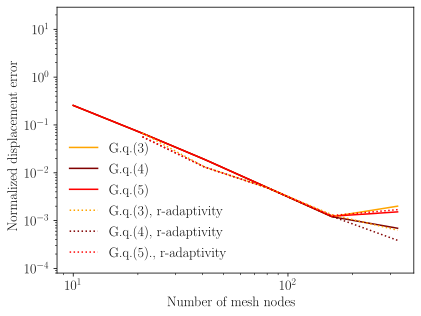

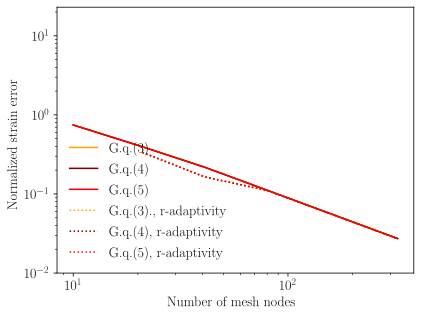

In [12]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

print("Fixed : ", loss_u[0,:,0])
print("Fixed : ", loss_u[0,:,1])
print("Fixed : ", loss_u[0,:,2])
print()
print("Adapt : ", loss_u[1,:,0])
print("Adapt : ", loss_u[1,:,1])
print("Adapt : ", loss_u[1,:,2])

print()

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_u[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_u[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_u[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_u[1,:,0],':', color = "orange", label = 'G.q.(3),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,2],':', color = "red", label = 'G.q.(5).,  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 29])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc="lower left", frameon=False )
plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_grad[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_grad[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_grad[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_grad[1,:,0],':', color = "orange", label = 'G.q.(3).,  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,2],':', color = "red", label = 'G.q.(5),  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.01, 23])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc="lower left", frameon=False )
plt.show()

